# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py and create directories

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py
        
if not os.path.exists('figs'):
    !mkdir figs
        
if not os.path.exists('tables'):
    !mkdir tables

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf, Cdf
from utils import decorate, savefig, write_table

In [4]:
from utils import normalize

def update_norm(prior, data):
    """Update the prior based on data.
    
    prior: joint distribution of mu and sigma
    data: sequence of observations
    """
    X, Y, Z = np.meshgrid(prior.columns, prior.index, data)
    likelihood = norm.pdf(Z, Y, X).prod(axis=2)

    posterior = prior * likelihood
    normalize(posterior)

    return posterior

In [5]:
def plot_contour(joint, **options):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    cs = plt.contour(joint.columns, joint.index, joint, **options)
    decorate(xlabel='Standard deviation', ylabel='Mean')
    return cs

In [6]:
from scipy.stats import gaussian_kde

def make_kde(pmf, n=101):
    """Make a kernel density estimate for a PMF.
    
    pmf: Pmf object
    n: number of points
    
    returns: Pmf object
    """
    kde = gaussian_kde(pmf.qs, weights=pmf.ps)
    qs = np.linspace(pmf.qs.min(), pmf.qs.max(), n)
    ps = kde.evaluate(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

**Exercise:** This question is inspired by [a question that appeared on Reddit](https://www.reddit.com/r/statistics/comments/hef2tw/r_statistics_in_a_mango_farm/).

Suppose you own a mango farm with 1800 trees.  Every year as harvest time approached, you would like to estimate the total weight of the mangos on the trees.

And suppose you hire a professional mango estimator who can look at a tree and estimate the total number of mangos and their average weight.  The estimator is not perfect, but they are pretty accurate on average.

Finally, suppose the estimator inspects 10 trees and reports the following data:

Mangos per tree: 50, 60, 70, 80, 90, 100...

Average weight in each tree: x, y, z

Compute posterior distributions for (1) the total number of mangos on all trees and (2) their total weight.

To get you started, I'll solve two easier problems:

1. First, suppose you know that the number of mangos in the trees is well described by a normal distribution with mean $\mu_n = 80$ and standard deviation $\sigma_n = 8$.  And suppose we compute the average weight of the mangos in each tree; some trees yield bigger mangos that others, but the distribution of averages is well describes by a normal distribution with mean $\mu_w = 150$ grams and standard deviation $\sigma_w = 15$ grams.  

I'll assign these parameters to variables and make `norm` objects to represent the distributions.

In [7]:
mu_n = 80
sigma_n = 8
mu_w = 150
sigma_w = 15

In [8]:
from scipy.stats import norm

dist_n = norm(mu_n, sigma_n)
dist_w = norm(mu_w, sigma_w)

Based on these parameters, what is the distribution for the total number of mangos on 1800 trees, and for their total weight?

To keep things simple, let's assume there is no correlation between the number of mangos and their size, so we can solve this problem by drawing random values from the two distributions independently.

In [9]:
sample_n = dist_n.rvs((1000, 1800))
sample_n.shape

(1000, 1800)

In [10]:
sample_total_n = sample_n.sum(axis=1)
sample_total_n.shape

(1000,)

In [11]:
sample_total_n.mean(), sample_total_n.std()

(143989.45329630317, 339.5205039844598)

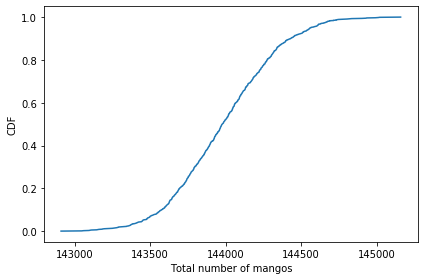

In [12]:
cdf_total_n = Cdf.from_seq(sample_total_n)
cdf_total_n.plot()

decorate(xlabel='Total number of mangos',
         ylabel='CDF')

In [13]:
sample_w = dist_w.rvs((1000, 1800))
sample_w.shape

(1000, 1800)

In [14]:
sample_total_w = (sample_n * sample_w).sum(axis=1) / 1000
sample_total_w.shape

(1000,)

In [15]:
sample_total_w.mean(), sample_total_w.std()

(21598.75793455604, 73.8731442313877)

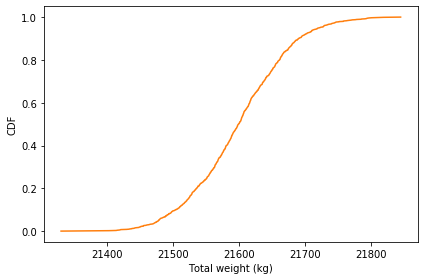

In [17]:
cdf_total_w = Cdf.from_seq(sample_total_w)
cdf_total_w.plot(color='C1')

decorate(xlabel='Total weight (kg)',
         ylabel='CDF')

In [19]:
def simulate_harvest(dist_n, dist_w, iters=1000, trees=1800):
    """Generate samples based on distributions of parameters.
    
    dist_n: distribution of number of mangos
    dist_w: distribution of mango weight
    iters: number of simulations
    trees: number of trees
    
    returns: tuple of samples, (number of mangos, total weight)
    """
    sample_n = dist_n.rvs((iters, trees))
    sample_total_n = sample_n.sum(axis=1)
    sample_w = dist_w.rvs((iters, trees))
    sample_total_w = (sample_n * sample_w).sum(axis=1) / 1000
    return sample_total_n, sample_total_w

2. Next, suppose we know from previous harvests that the parameters we used in the previous step vary from year to year, depending on the ages of the trees, weather, and other factors.  And suppose that the distributions of $\mu_n$ and $\mu_w$ are well modeled by normal distributions, and the distributions of $\sigma^2_n$ and $\sigma^2_w$, under the transformation
$t = n s^2 / \sigma^2$, are well-modeled by chi-square distributions, (where $n$ is the sample size, $s$ is the sample standard deviation, and $\sigma$ is the population standard deviation).

In [110]:
from scipy.stats import chi2

dist_mu_n = norm(70, 15)
dist_mu_w = norm(140, 20)
dist_sigma_n = norm(10, 3)
dist_sigma_w = norm(15, 5)

In [111]:
def make_pmf(dist, low, high, n=101):
    """Make a Pmf that approximates a distribution.
    
    dist: distribution
    low: lower bound
    high: upper bound
    n: number of points
    
    returns: Pmf
    """
    qs = np.linspace(low, high, n)
    ps = dist.pdf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

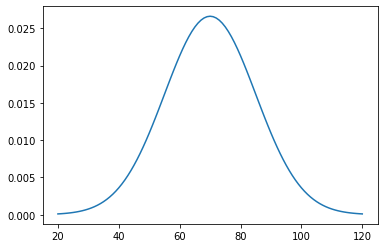

In [112]:
pmf_mu_n = make_pmf(dist_mu_n, 20, 120)
pmf_mu_n.plot()

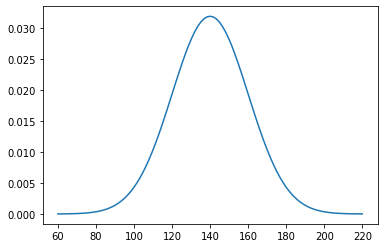

In [113]:
pmf_mu_w = make_pmf(dist_mu_w, 60, 220)
pmf_mu_w.plot()

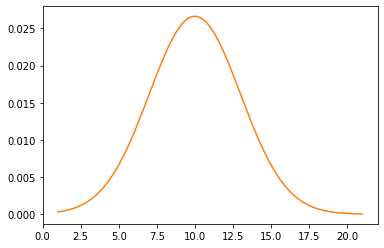

In [139]:
pmf_sigma_n = make_pmf(dist_sigma_n, 1, 21)
pmf_sigma_n.plot(color='C1')

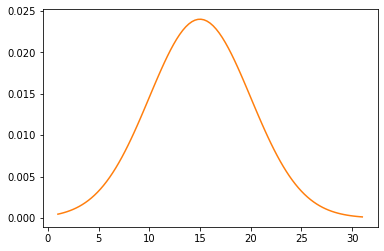

In [140]:
pmf_sigma_w = make_pmf(dist_sigma_w, 1, 31)
pmf_sigma_w.plot(color='C1')

In [141]:
def sample_parameters(dist_mu, dist_sigma, iters=1000):
    """Sample from the distributions of parameters.
    
    dist_mu: distribution of the population mean
    dist_sigma: distribution of the population std
    iters: number of rows in the result
    
    returns: array with one column per parameters
    """
    sample_mu = dist_mu.rvs(iters)
    sample_sigma = dist_sigma.rvs(iters)
    parameters = np.transpose([sample_mu, sample_sigma])
    return parameters

In [142]:
parameters_n = sample_parameters(dist_mu_n, dist_sigma_n)
parameters_n.shape

(1000, 2)

In [143]:
parameters_n.mean(axis=0)

array([69.77846454, 10.02333357])

In [144]:
parameters_w = sample_parameters(dist_mu_w, dist_sigma_w)
parameters_w.shape

(1000, 2)

In [145]:
parameters_w.mean(axis=0)

array([140.05835092,  15.15800028])

In [146]:
parameters = np.hstack([parameters_n, parameters_w])
parameters.shape

(1000, 4)

In [147]:
def run_simulations(parameters):
    """Run a simulated harvest for each row of parameters.
    
    parameters: array with one column per parameter
    
    returns: array with one column for total mangos and
             one column for total weight
    """
    sample_totals = []

    for mu_n, sigma_n, mu_w, sigma_w in parameters:
        dist_n = norm(mu_n, sigma_n)
        dist_w = norm(mu_w, sigma_w)
        totals = simulate_harvest(dist_n, dist_w, iters=1)
        sample_totals.append(totals)
        
    a = np.array(sample_totals)
    return a.reshape((1000, 2)).transpose()

In [148]:
sample2_total_n, sample2_total_w = run_simulations(parameters)

In [149]:
sample2_total_n.mean(), sample2_total_n.std()

(125604.05124205459, 27565.540626132337)

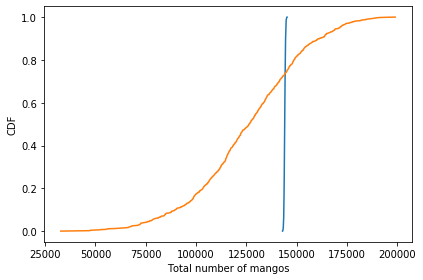

In [150]:
cdf_total_n = Cdf.from_seq(sample_total_n)
cdf_total_n.plot()

cdf2_total_n = Cdf.from_seq(sample2_total_n)
cdf2_total_n.plot()

decorate(xlabel='Total number of mangos',
         ylabel='CDF')

In [151]:
sample2_total_w.mean(), sample2_total_w.std()

(17583.46649089755, 4644.319596604624)

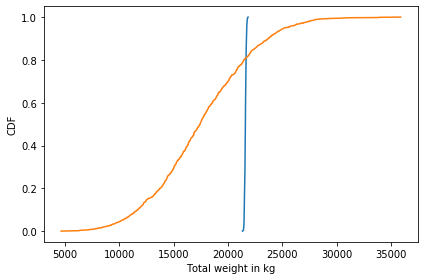

In [152]:
cdf_total_w = Cdf.from_seq(sample_total_w)
cdf_total_w.plot()

cdf2_total_w = Cdf.from_seq(sample2_total_w)
cdf2_total_w.plot()

decorate(xlabel='Total weight in kg',
         ylabel='CDF')

## Generate fake data

In [161]:
mu_n = 80
sigma_n = 8
mu_w = 150
sigma_w = 15

In [162]:
dist_n = norm(mu_n, sigma_n)
dist_w = norm(mu_w, sigma_w)

In [163]:
sample_size = 10
data_n = dist_n.rvs(sample_size).astype(int)
data_n

array([74, 72, 65, 73, 67, 89, 85, 70, 75, 80])

In [164]:
data_w = dist_w.rvs(sample_size).astype(int)
data_w

array([135, 118, 136, 176, 166, 165, 175, 190, 164, 153])

## Update the distributions

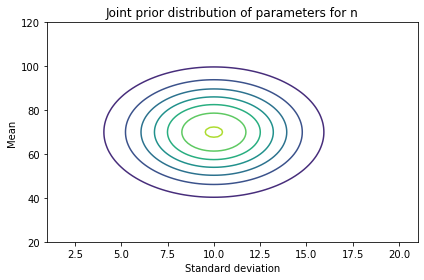

In [165]:
from utils import outer_product

prior_n = outer_product(pmf_mu_n, pmf_sigma_n)
plot_contour(prior_n)
decorate(title='Joint prior distribution of parameters for n')

In [166]:
posterior_n = update_norm(prior_n, data_n)
posterior_n.to_numpy().sum()

0.9999999999999998

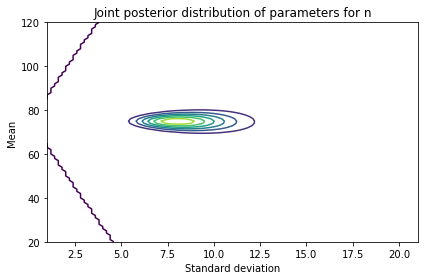

In [167]:
plot_contour(posterior_n)
decorate(title='Joint posterior distribution of parameters for n')

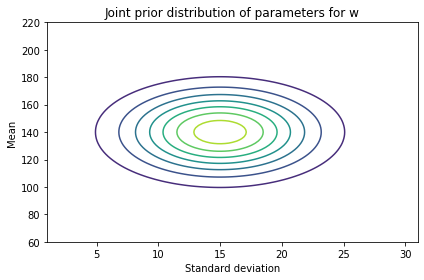

In [168]:
prior_w = outer_product(pmf_mu_w, pmf_sigma_w)
plot_contour(prior_w)
decorate(title='Joint prior distribution of parameters for w')

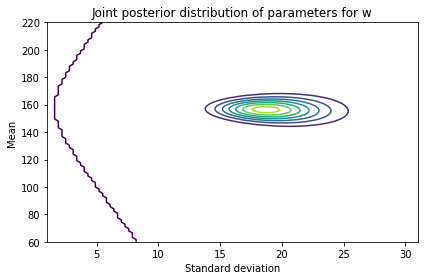

In [169]:
posterior_w = update_norm(prior_w, data_w)
plot_contour(posterior_w)
decorate(title='Joint posterior distribution of parameters for w')

## Posterior predictive distributions



In [170]:
from utils import marginal

marginal_mu_n = marginal(posterior_n, 1)
pmf_mu_n.mean(), data_n.mean(), marginal_mu_n.mean()

(70.00000000000001, 75.0, 74.82116612324629)

In [171]:
marginal_sigma_n = marginal(posterior_n, 0)
pmf_sigma_n.mean(), data_n.std(), marginal_sigma_n.mean()

(10.010748154085311, 7.238784428341543, 8.972027617693856)

In [172]:
marginal_mu_w = marginal(posterior_w, 1)
pmf_mu_w.mean(), data_w.mean(), marginal_mu_w.mean()

(140.0, 157.8, 156.1991439188851)

In [173]:
marginal_sigma_w = marginal(posterior_w, 0)
pmf_sigma_w.mean(), data_w.std(), marginal_sigma_w.mean()

(15.02560017746442, 21.03235602589496, 19.74272668710127)

In [174]:
sample_mu_n = marginal_mu_n.choice(1000)
sample_mu_n.mean()

74.756

In [175]:
sample_sigma_n = marginal_sigma_n.choice(1000)
sample_sigma_n.mean()

9.103

In [176]:
sample_mu_w = marginal_mu_w.choice(1000)
sample_mu_w.mean()

156.5136

In [177]:
sample_sigma_w = marginal_sigma_w.choice(1000)
sample_sigma_w.mean()

19.7329

In [178]:
parameters = np.transpose([sample_mu_n, sample_sigma_n,
                           sample_mu_w, sample_sigma_w])
parameters.mean(axis=0)

array([ 74.756 ,   9.103 , 156.5136,  19.7329])

In [179]:
sample3_total_n, sample3_total_w = run_simulations(parameters)

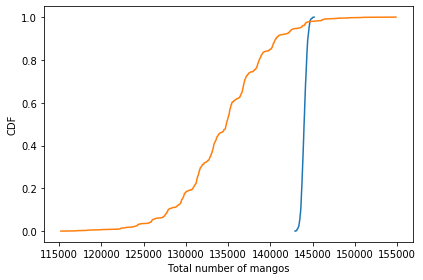

In [180]:
cdf_total_n = Cdf.from_seq(sample_total_n)
cdf_total_n.plot()

cdf3_total_n = Cdf.from_seq(sample3_total_n)
cdf3_total_n.plot()

decorate(xlabel='Total number of mangos',
         ylabel='CDF')

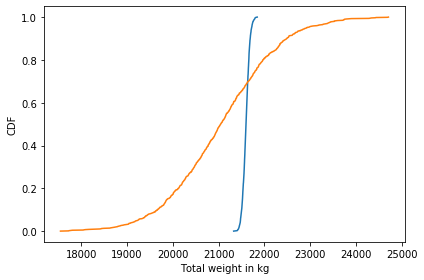

In [181]:
cdf_total_w = Cdf.from_seq(sample_total_w)
cdf_total_w.plot()

cdf3_total_w = Cdf.from_seq(sample3_total_w)
cdf3_total_w.plot()

decorate(xlabel='Total weight in kg',
         ylabel='CDF')

In [182]:
import pymc3 as pm


In [183]:
with pm.Model() as model:
    
    mu = pm.Normal('mu', dist_mu_n.mean(), dist_mu_n.std())
    sigma = pm.HalfNormal('sigma', 50)

    # define likelihood
    obs = pm.Normal('obs', mu=mu, sd=sigma, observed=data_n)

In [184]:
with model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:01<00:00, 1948.45draws/s]


/home/downey/anaconda3/envs/ThinkBayes2/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/downey/anaconda3/envs/ThinkBayes2/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/downey/anaconda3/envs/ThinkBayes2/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/downey/anaconda3/envs/ThinkBayes2/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument b

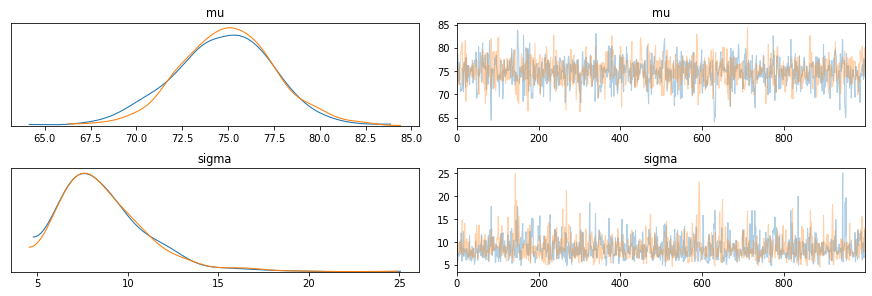

In [185]:
with model:
    pm.traceplot(trace)

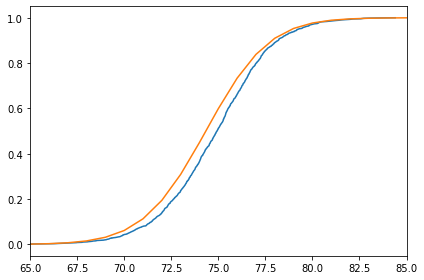

In [186]:
cdf_mu = Cdf.from_seq(trace['mu'])
cdf_mu.plot()
marginal_mu_n.make_cdf().plot()

decorate(xlim=[65, 85])

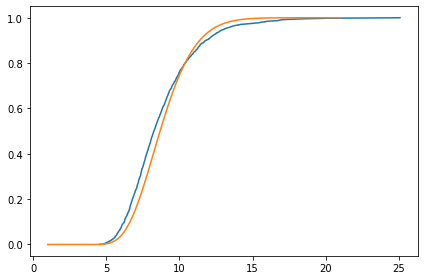

In [187]:
cdf_sigma = Cdf.from_seq(trace['sigma'])
cdf_sigma.plot()
marginal_sigma_n.make_cdf().plot()

decorate()